In [4]:
import shutil

# Replace 'data_folder' with your actual folder name
shutil.make_archive('models_vit_with_mlp', 'zip', 'vit_mlp')

'/home/y2b/cnn_lstm_root_architecture/ViT/models_vit_with_mlp.zip'

In [1]:
from inference import pipeline
import os

models_dir = 'vit_no_mlp'
data_dir = '../Unet/data_v1_unprocessed/test'
for model in os.listdir(models_dir):
    model_path = os.path.join(models_dir, model)
    pipeline(data_dir, model_path)

2025-09-05 14:52:18.829150: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 14:52:18.871685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-05 14:52:18.871722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-05 14:52:18.873045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 14:52:18.879538: I tensorflow/core/platform/cpu_feature_guar

2/2 [==============================] - 0s 34ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 33ms/step
=== Average Metrics ===
Avg F1 Score: 0.7141
Avg mIoU: 0.5572
Avg Precision: 0.8489
Avg Recall: 0.6185
2/2 [==============================] - 0s 34ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 32ms/step
=== Average Metrics ===
Avg F1 Score: 0.6913
Avg mIoU: 0.5315
Avg Precision: 0.9235
Avg Recall: 0.5553
2/2 [==============================] - 0s 32ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 32ms/step
=== Average Metrics ===
Avg F1 Score: 0.7361
Avg mIoU: 0.5834
Avg Precision: 0.8410
Avg Recall: 0.6554
2/2 [==============================] - 0s 36ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 33ms/step
=== Average Metrics ===
Avg F1 Score: 0.7232
Avg mIoU: 

In [3]:
from inference import pipeline
import os

models_dir = 'vit_with_mlp'
data_dir = '../Unet/data_v1_unprocessed/test'
for model in os.listdir(models_dir):
    model_path = os.path.join(models_dir, model)
    pipeline(data_dir, model_path)

2/2 [==============================] - 0s 24ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 23ms/step
=== Average Metrics ===
Avg F1 Score: 0.7010
Avg mIoU: 0.5422
Avg Precision: 0.8519
Avg Recall: 0.5983
2/2 [==============================] - 0s 23ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 24ms/step
=== Average Metrics ===
Avg F1 Score: 0.6526
Avg mIoU: 0.4864
Avg Precision: 0.8954
Avg Recall: 0.5154
2/2 [==============================] - 0s 23ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 25ms/step
=== Average Metrics ===
Avg F1 Score: 0.7157
Avg mIoU: 0.5596
Avg Precision: 0.8569
Avg Recall: 0.6168
2/2 [==============================] - 0s 24ms/step
Skipping frame as ground truth has no positive pixels.
2/2 [==============================] - 0s 23ms/step
=== Average Metrics ===
Avg F1 Score: 0.6811
Avg mIoU: 

In [ ]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def pipeline(image_dir, model_path, kernel_size=5, patch_size=256, view=False):
        files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

        model = load_model(model_path, custom_objects={"f1": f1})
    
        all_f1 = []
        all_iou = []
        all_precision = []
        all_recall = []
    
        # Assume masks are in a 'masks' subfolder inside image_dir, with matching filenames
        mask_dir = image_dir
    
        for file in files:
            if file.endswith('.png'):
                # Read and preprocess image
                img_path = os.path.join(image_dir, file)
                image = cv2.imread(img_path, 0)  # grayscale
                image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
                image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
                image_np = image_color / 255.0
    
                # Pad and patchify
                image_padded = padder(image_np, patch_size=patch_size)
                patches = patchify(image_padded, (patch_size, patch_size, 1), step=patch_size)
                expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
                patches = patches.reshape(-1, patch_size, patch_size, 1)
    
                # Predict patches and unpatchify
                predicted_patches = model.predict(patches)
                predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
                predicted_patches = predicted_patches[:, :, :, :, 0]
                prediction = unpatchify(predicted_patches, image_padded.shape[:2])
    
                # Threshold prediction to get binary mask
                prediction_bool = (prediction > 0.5).astype(np.uint8)
    
                # Load the actual mask and preprocess it to match prediction size
                mask_path = os.path.join(mask_dir, file).replace('.png', '.tif')
                if not os.path.exists(mask_path):
                    print(f"Mask for {file} not found, skipping...")
                    continue
                mask = cv2.imread(mask_path, 0)  # grayscale mask
                mask = crop_to_coordinates(mask, stats, centroids)
                mask = padder(mask, patch_size=patch_size)
                mask_bool = (mask > 0.5).astype(np.uint8)
    
                if np.sum(mask_bool) == 0:
                    print(f"Skipping frame as ground truth has no positive pixels.")
                    continue
                
                # Flatten masks for metrics
                pred_flat = prediction_bool.flatten()
                mask_flat = mask_bool.flatten()
    
                # Calculate metrics
                f1_val = f1_metric(mask_flat, pred_flat)
                iou_val = jaccard_score(mask_flat, pred_flat)
                precision_val = precision_score(mask_flat, pred_flat)
                recall_val = recall_score(mask_flat, pred_flat)
    
                # Store metrics
                all_f1.append(f1_val)
                all_iou.append(iou_val)
                all_precision.append(precision_val)
                all_recall.append(recall_val)
    
                # print(f"Metrics for {file}:")
                # print(f"  F1 Score: {f1_val:.4f} | mIoU: {iou_val:.4f} | Precision: {precision_val:.4f} | Recall: {recall_val:.4f}\n")
    
                if view:
                    # Plot side-by-side: original image, predicted mask, actual mask
                    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
        
                    axs.imshow(prediction_bool, cmap='gray')
                    axs.set_title(f"Predicted Mask (F1: {f1_val:.3f})")
                    axs.axis("off")
        
                    plt.tight_layout()
                    plt.show()
    
        # After processing all images, print average metrics
        if all_f1:
            print("=== Average Metrics ===")
            print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
            print(f"Avg mIoU: {np.mean(all_iou):.4f}")
            print(f"Avg Precision: {np.mean(all_precision):.4f}")
            print(f"Avg Recall: {np.mean(all_recall):.4f}")
        else:
            print("No valid images/masks were processed.")

model_path = 'vit_with_mlp/vit_with_mlp_run1.h5'
data_dir = '../Unet/data_v1_unprocessed/test'
pipeline(data_dir, model_path, view=True)

FileNotFoundError: [Errno 2] No such file or directory: '../Unet/data_v1_unprocessed/test'

In [ ]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def pipeline(image_dir, model_path, kernel_size=5, patch_size=256, view=False):
        files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

        model = load_model(model_path, custom_objects={"f1": f1})
    
        all_f1 = []
        all_iou = []
        all_precision = []
        all_recall = []
    
        # Assume masks are in a 'masks' subfolder inside image_dir, with matching filenames
        mask_dir = image_dir
    
        for file in files:
            if file.endswith('.png'):
                # Read and preprocess image
                img_path = os.path.join(image_dir, file)
                image = cv2.imread(img_path, 0)  # grayscale
                image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
                image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
                image_np = image_color / 255.0
    
                # Pad and patchify
                image_padded = padder(image_np, patch_size=patch_size)
                patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
                expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
                patches = patches.reshape(-1, patch_size, patch_size, 1)
    
                # Predict patches and unpatchify
                predicted_patches = model.predict(patches)
                predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
                predicted_patches = predicted_patches[:, :, :, :, 0]
                prediction = unpatchify(predicted_patches, image_padded.shape[:2])
    
                # Threshold prediction to get binary mask
                prediction_bool = (prediction > 0.5).astype(np.uint8)
    
                # Load the actual mask and preprocess it to match prediction size
                mask_path = os.path.join(mask_dir, file).replace('.png', '.tif')
                if not os.path.exists(mask_path):
                    print(f"Mask for {file} not found, skipping...")
                    continue
                mask = cv2.imread(mask_path, 0)  # grayscale mask
                mask = crop_to_coordinates(mask, stats, centroids)
                mask = padder(mask, patch_size=patch_size)
                mask_bool = (mask > 0.5).astype(np.uint8)
    
                if np.sum(mask_bool) == 0:
                    print(f"Skipping frame as ground truth has no positive pixels.")
                    continue
                
                # Flatten masks for metrics
                pred_flat = prediction_bool.flatten()
                mask_flat = mask_bool.flatten()
    
                # Calculate metrics
                f1_val = f1_metric(mask_flat, pred_flat)
                iou_val = jaccard_score(mask_flat, pred_flat)
                precision_val = precision_score(mask_flat, pred_flat)
                recall_val = recall_score(mask_flat, pred_flat)
    
                # Store metrics
                all_f1.append(f1_val)
                all_iou.append(iou_val)
                all_precision.append(precision_val)
                all_recall.append(recall_val)
    
                # print(f"Metrics for {file}:")
                # print(f"  F1 Score: {f1_val:.4f} | mIoU: {iou_val:.4f} | Precision: {precision_val:.4f} | Recall: {recall_val:.4f}\n")
    
                if view:
                    # Plot side-by-side: original image, predicted mask, actual mask
                    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
        
                    axs.imshow(prediction_bool, cmap='gray')
                    axs.set_title(f"Predicted Mask (F1: {f1_val:.3f})")
                    axs.axis("off")
        
                    plt.tight_layout()
                    plt.show()
    
        # After processing all images, print average metrics
        if all_f1:
            print("=== Average Metrics ===")
            print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
            print(f"Avg mIoU: {np.mean(all_iou):.4f}")
            print(f"Avg Precision: {np.mean(all_precision):.4f}")
            print(f"Avg Recall: {np.mean(all_recall):.4f}")
        else:
            print("No valid images/masks were processed.")

model_path = 'vit_no_mlp/vit_no_mlp_run4.h5'
data_dir = '../Unet/data_v1_unprocessed/test'
pipeline(data_dir, model_path, view=True)

FileNotFoundError: [Errno 2] No such file or directory: '../Unet/data_v1_unprocessed/test'

# Inference with root measurement

Found 5 models in directory

Processing model: vit_with_mlp_run1.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_with_mlp_run1.h5 ===
Avg F1 Score: 0.7153
Avg mIoU: 0.5609
Avg Precision: 0.9078
Avg Recall: 0.5929


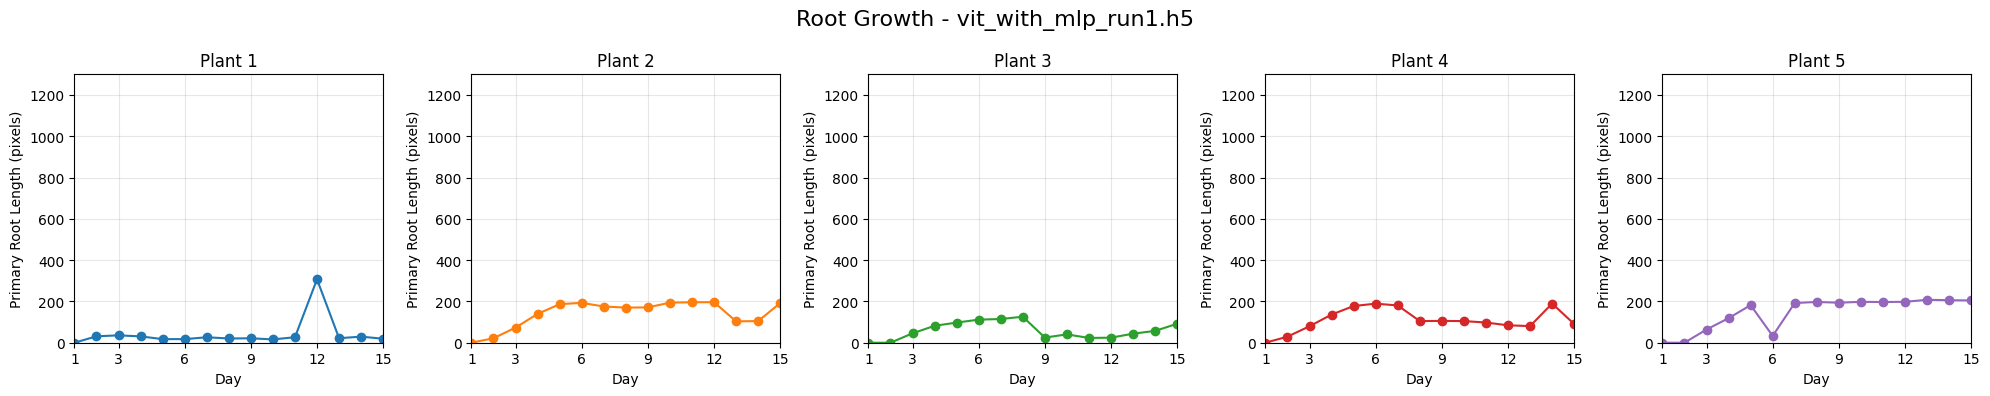


Processing model: vit_with_mlp_run2.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_with_mlp_run2.h5 ===
Avg F1 Score: 0.6831
Avg mIoU: 0.5231
Avg Precision: 0.9170
Avg Recall: 0.5477


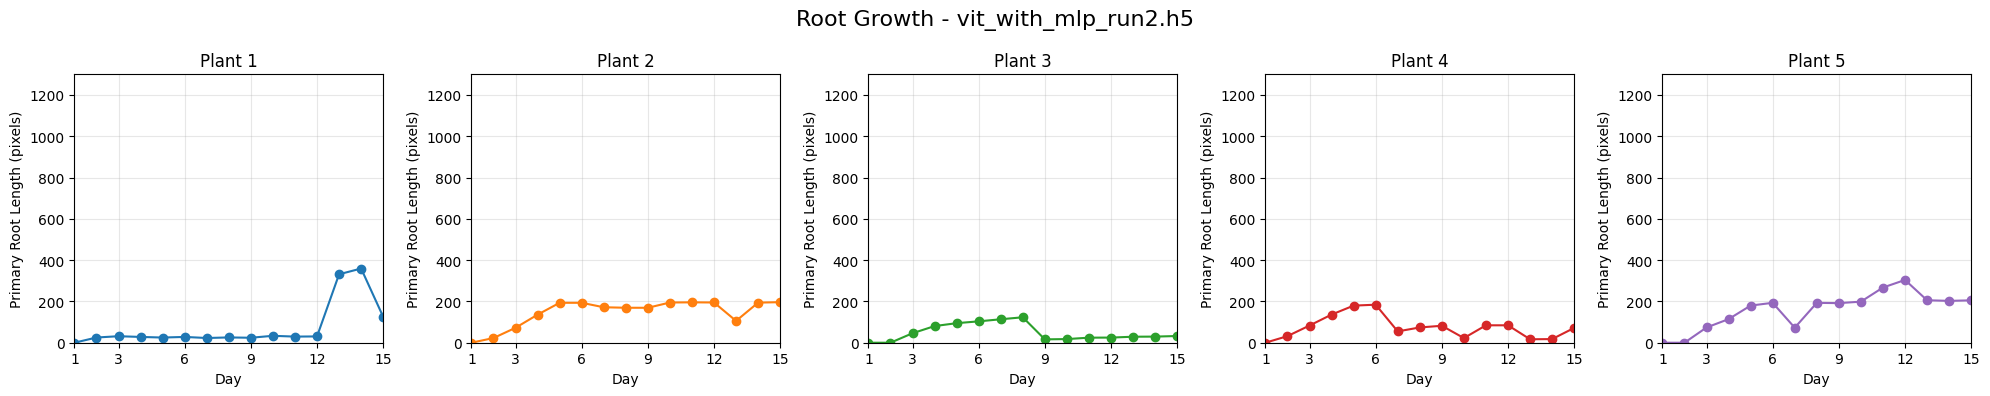


Processing model: vit_with_mlp_run3.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_with_mlp_run3.h5 ===
Avg F1 Score: 0.6353
Avg mIoU: 0.4699
Avg Precision: 0.9341
Avg Recall: 0.4854


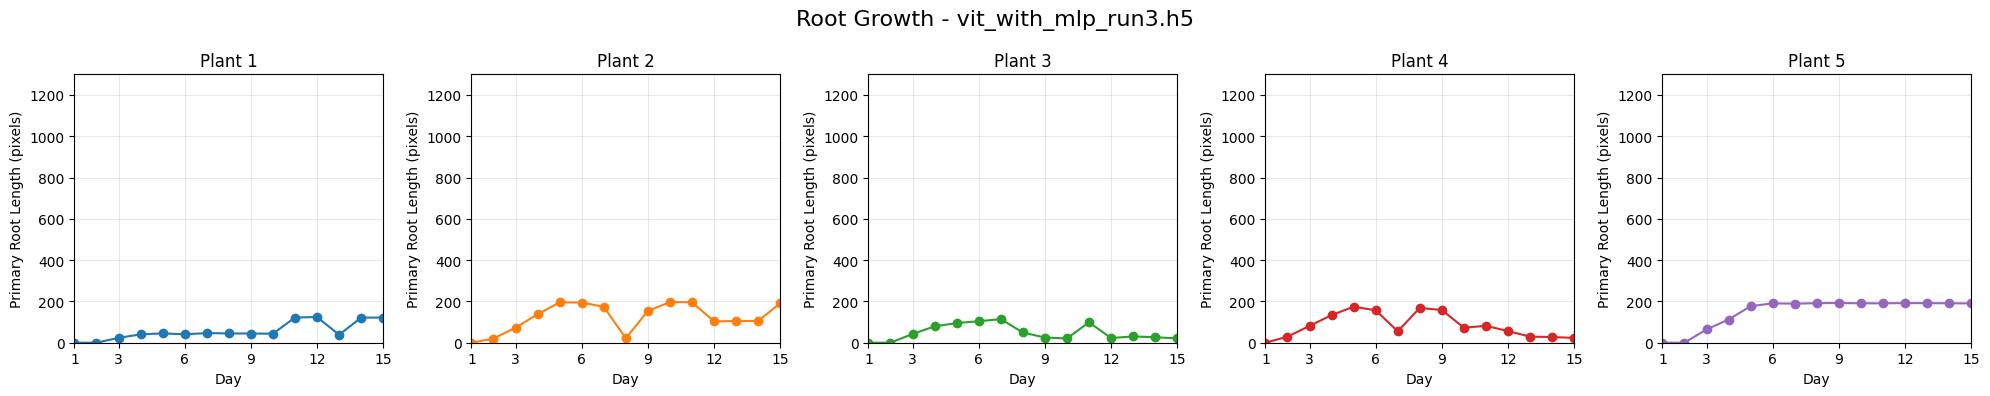


Processing model: vit_with_mlp_run4.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_with_mlp_run4.h5 ===
Avg F1 Score: 0.7372
Avg mIoU: 0.5867
Avg Precision: 0.9121
Avg Recall: 0.6202


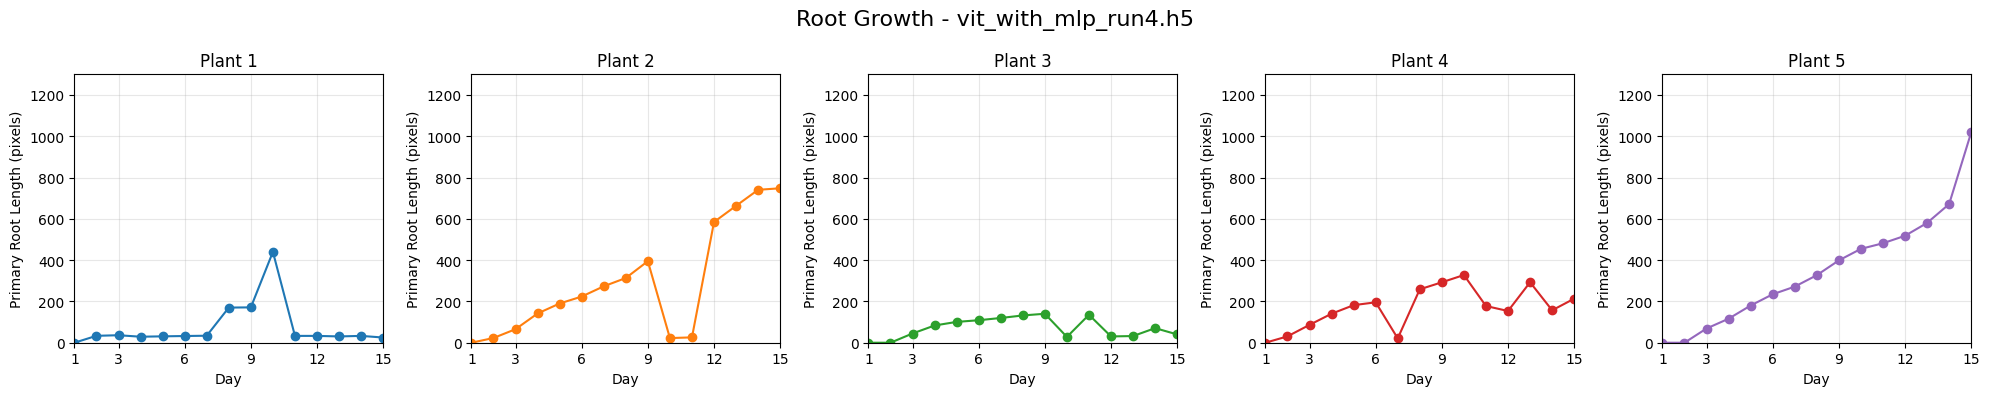


Processing model: vit_with_mlp_run5.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_with_mlp_run5.h5 ===
Avg F1 Score: 0.7041
Avg mIoU: 0.5476
Avg Precision: 0.9093
Avg Recall: 0.5777


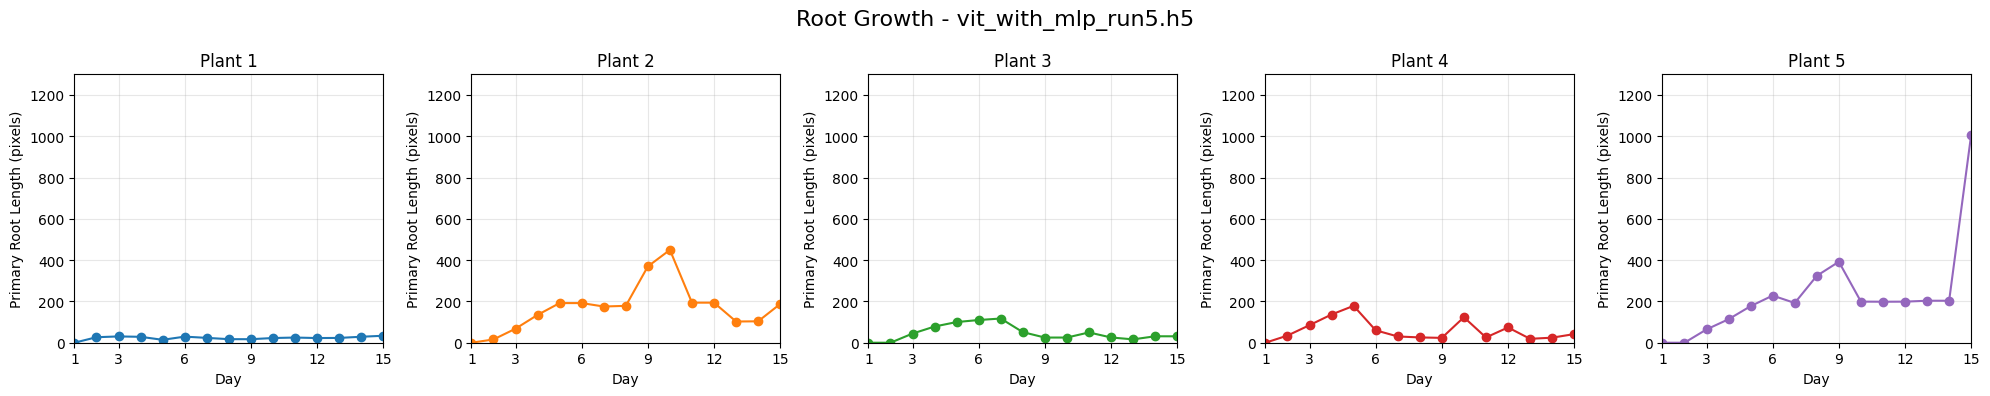


SUMMARY - All Models

vit_with_mlp_run1.h5:
  F1: 0.7153 | IoU: 0.5609 | Precision: 0.9078 | Recall: 0.5929

vit_with_mlp_run2.h5:
  F1: 0.6831 | IoU: 0.5231 | Precision: 0.9170 | Recall: 0.5477

vit_with_mlp_run3.h5:
  F1: 0.6353 | IoU: 0.4699 | Precision: 0.9341 | Recall: 0.4854

vit_with_mlp_run4.h5:
  F1: 0.7372 | IoU: 0.5867 | Precision: 0.9121 | Recall: 0.6202

vit_with_mlp_run5.h5:
  F1: 0.7041 | IoU: 0.5476 | Precision: 0.9093 | Recall: 0.5777


In [1]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
from skimage.morphology import remove_small_objects
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1
from root_measurement import segment_image, measuring_skeleton
import warnings
warnings.filterwarnings('ignore')

os.environ['TF_USE_LEGACY_KERAS'] = '1'

def pipeline(image_dir, model_path, kernel_size=5, patch_size=256, view_masks=False, view_growth=True):
    # Check if model_path is a directory or a single file
    if os.path.isdir(model_path):
        model_files = sorted([os.path.join(model_path, f) for f in os.listdir(model_path) if f.endswith('.h5')])
        print(f"Found {len(model_files)} models in directory")
    else:
        model_files = [model_path]
    
    # Store results for all models
    all_model_results = {}
    
    for model_file in model_files:
        model_name = os.path.basename(model_file)
        print(f"\n{'='*60}")
        print(f"Processing model: {model_name}")
        print(f"{'='*60}")
        
        files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

        model = load_model(model_file, custom_objects={"f1": f1})

        all_f1 = []
        all_iou = []
        all_precision = []
        all_recall = []
        
        # Store root lengths for each plant across all images
        plant_root_lengths = {i: [] for i in range(5)}  # 5 plants
        image_names = []
        
        mask_dir = image_dir.replace('images/images', 'masks/masks')

        for file in files:
            if file.endswith('.png'):
                image_names.append(file)
                # Read and preprocess image
                img_path = os.path.join(image_dir, file)
                image = cv2.imread(img_path, 0)  # grayscale
                image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
                image_np = image_cropped / 255.0

                # Pad and patchify
                image_padded = padder(image_np, patch_size=patch_size)
                
                # Add channel dimension AFTER padding
                image_padded = np.expand_dims(image_padded, axis=-1)  # (H, W, 1)
                
                patches = patchify(image_padded, (patch_size, patch_size, 1), step=patch_size)
                expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
                patches = patches.reshape(-1, patch_size, patch_size, 1)

                # Predict patches and unpatchify
                predicted_patches = model.predict(patches, verbose=0)
                predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
                predicted_patches = predicted_patches[:, :, :, :, 0]
                prediction = unpatchify(predicted_patches, image_padded.shape[:2])

                # Threshold prediction to get binary mask
                prediction_bool = (prediction > 0.5).astype(bool)

                prediction_bool = remove_small_objects(prediction_bool, min_size=50)
                prediction_bool = prediction_bool.astype(np.uint8)

                # Load the actual mask and preprocess it to match prediction size
                mask_path = os.path.join(mask_dir, file).replace('.png', '.tif')
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, 0)  # grayscale mask
                    mask = crop_to_coordinates(mask, stats, centroids)
                    mask = padder(mask, patch_size=patch_size)
                    mask_bool = (mask > 0.5).astype(np.uint8)
                    
                    # Ensure prediction and mask have same shape
                    if prediction_bool.shape != mask_bool.shape:
                        print(f"Shape mismatch in {file}: pred {prediction_bool.shape}, mask {mask_bool.shape}")
                        continue

                    if np.sum(mask_bool) > 0:
                        # Flatten masks for metrics
                        pred_flat = prediction_bool.flatten()
                        mask_flat = mask_bool.flatten()
        
                        # Calculate metrics
                        f1_val = f1_metric(mask_flat, pred_flat)
                        iou_val = jaccard_score(mask_flat, pred_flat)
                        precision_val = precision_score(mask_flat, pred_flat)
                        recall_val = recall_score(mask_flat, pred_flat)
        
                        # Store metrics
                        all_f1.append(f1_val)
                        all_iou.append(iou_val)
                        all_precision.append(precision_val)
                        all_recall.append(recall_val)
        
                        if view_masks:
                            # Plot side-by-side: original image, predicted mask, actual mask
                            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                            axs[0].imshow(image_np, cmap='gray')
                            axs[0].set_title("Original Image")
                            axs[0].axis("off")
                
                            axs[1].imshow(prediction_bool, cmap='gray')
                            axs[1].set_title("Predicted Mask")
                            axs[1].axis("off")
                
                            axs[2].imshow(mask_bool, cmap='gray')
                            axs[2].set_title("Actual Mask")
                            axs[2].axis("off")
                
                            plt.tight_layout()
                            plt.show()
                    else:
                        print(f"Skipping frame {file} as ground truth has no positive pixels.")
                else:
                    print(f"Mask for {file} not found, skipping metrics...")
                
                # Segment into 5 plants and measure roots
                segments = segment_image(prediction_bool)
                
                for plant_idx, segment in enumerate(segments):
                    try:
                        if np.sum(segment) > 0:  # Check if there's any root detected
                            root_length = measuring_skeleton(segment)
                            plant_root_lengths[plant_idx].append(root_length)
                        else:
                            plant_root_lengths[plant_idx].append(0)
                    except Exception as e:
                        print(f"Error measuring plant {plant_idx} in {file}: {e}")
                        plant_root_lengths[plant_idx].append(0)

        # Print average metrics for this model
        if all_f1:
            print(f"\n=== Average Metrics for {model_name} ===")
            print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
            print(f"Avg mIoU: {np.mean(all_iou):.4f}")
            print(f"Avg Precision: {np.mean(all_precision):.4f}")
            print(f"Avg Recall: {np.mean(all_recall):.4f}")
        else:
            print(f"No valid images/masks were processed for {model_name}.")
        
        # Store results for this model
        all_model_results[model_name] = {
            'f1': np.mean(all_f1) if all_f1 else 0,
            'iou': np.mean(all_iou) if all_iou else 0,
            'precision': np.mean(all_precision) if all_precision else 0,
            'recall': np.mean(all_recall) if all_recall else 0,
            'plant_root_lengths': plant_root_lengths
        }
        
        # Create separate line plots for each plant's root growth
        if view_growth:
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            fig.suptitle(f'Root Growth - {model_name}', fontsize=16)
            for plant_idx in range(5):
                # Add 0 at the start if list has 14 measurements (missing day 1)
                root_data = plant_root_lengths[plant_idx]
                if len(root_data) == 14:
                    root_data = [0] + root_data
                
                x_values = range(1, len(root_data) + 1)
                axes[plant_idx].plot(x_values, 
                                    root_data, 
                                    marker='o', 
                                    color=f'C{plant_idx}')
                axes[plant_idx].set_xlabel('Day')
                axes[plant_idx].set_ylabel('Primary Root Length (pixels)')
                axes[plant_idx].set_title(f'Plant {plant_idx + 1}')
                axes[plant_idx].set_ylim(0, 1300)
                axes[plant_idx].set_xlim(1, 15)
                axes[plant_idx].set_xticks([1, 3, 6, 9, 12, 15])
                axes[plant_idx].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # Print summary of all models
    if len(all_model_results) > 1:
        print(f"\n{'='*60}")
        print("SUMMARY - All Models")
        print(f"{'='*60}")
        for model_name, results in all_model_results.items():
            print(f"\n{model_name}:")
            print(f"  F1: {results['f1']:.4f} | IoU: {results['iou']:.4f} | Precision: {results['precision']:.4f} | Recall: {results['recall']:.4f}")
    
    return all_model_results

# Directory of models
model_path = 'models_vit_mlp'
data_dir = '../test_data_full/images/images'
results = pipeline(data_dir, model_path, view_masks=False, view_growth=True)

Found 5 models in directory

Processing model: vit_no_mlp_run1.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_no_mlp_run1.h5 ===
Avg F1 Score: 0.7308
Avg mIoU: 0.5790
Avg Precision: 0.9035
Avg Recall: 0.6166


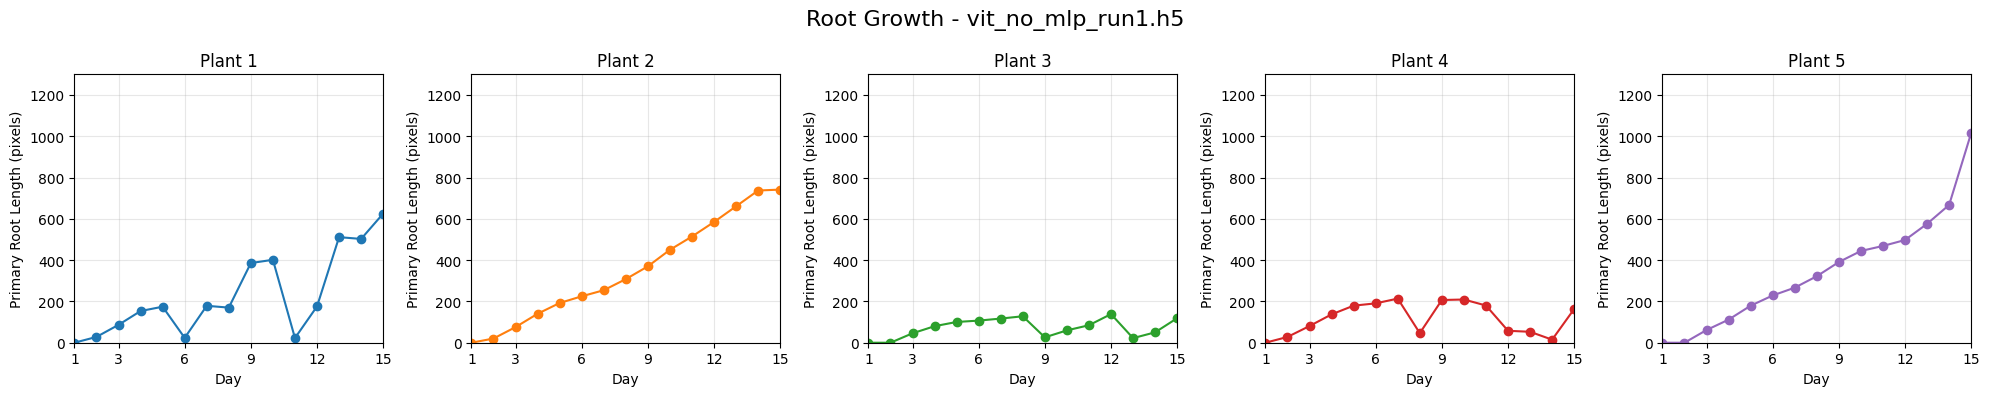


Processing model: vit_no_mlp_run2.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_no_mlp_run2.h5 ===
Avg F1 Score: 0.6699
Avg mIoU: 0.5097
Avg Precision: 0.9307
Avg Recall: 0.5285


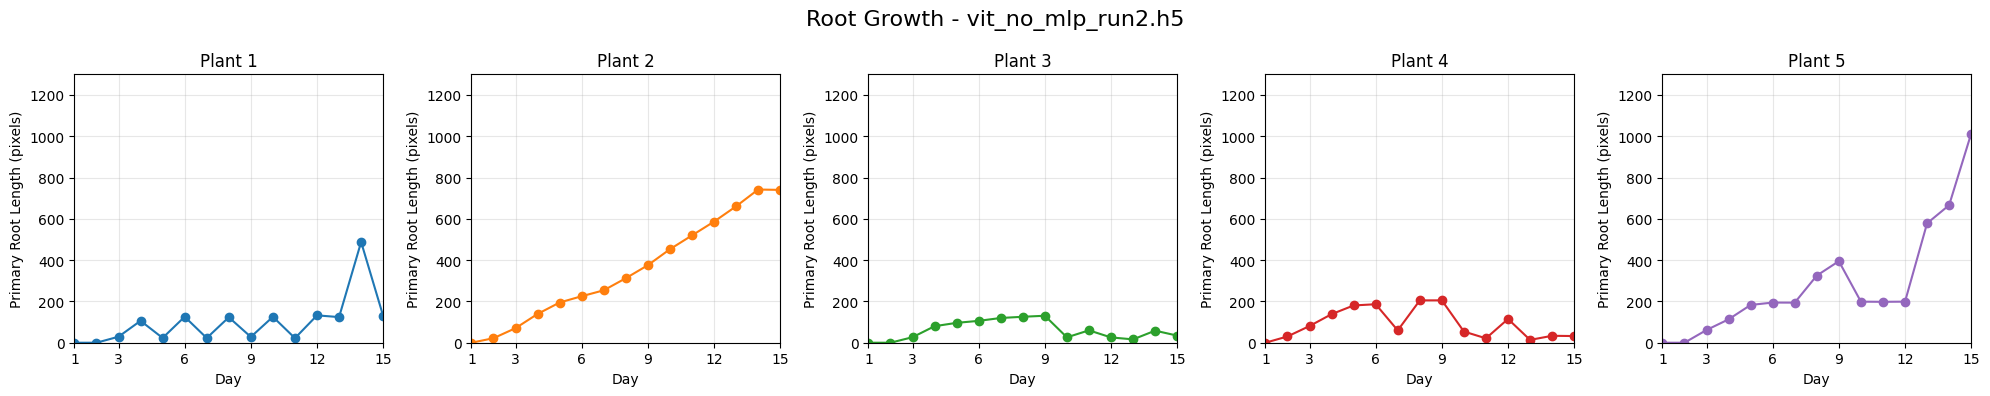


Processing model: vit_no_mlp_run3.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_no_mlp_run3.h5 ===
Avg F1 Score: 0.6929
Avg mIoU: 0.5339
Avg Precision: 0.9309
Avg Recall: 0.5549


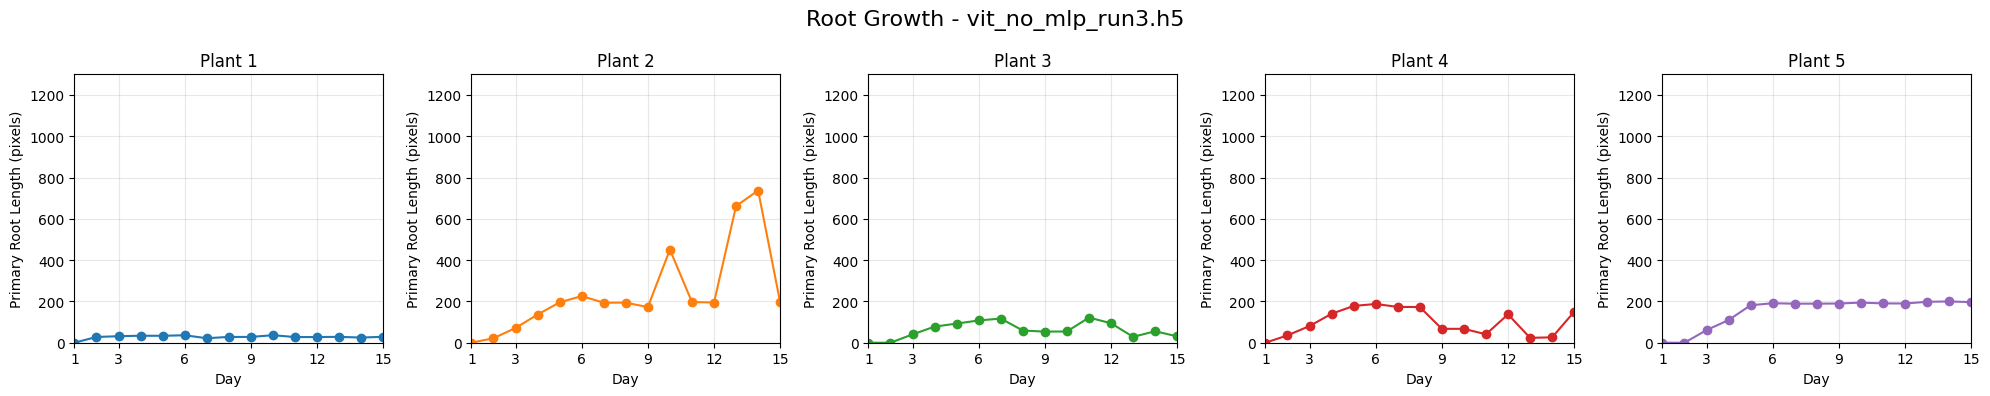


Processing model: vit_no_mlp_run4.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_no_mlp_run4.h5 ===
Avg F1 Score: 0.7391
Avg mIoU: 0.5888
Avg Precision: 0.9091
Avg Recall: 0.6247


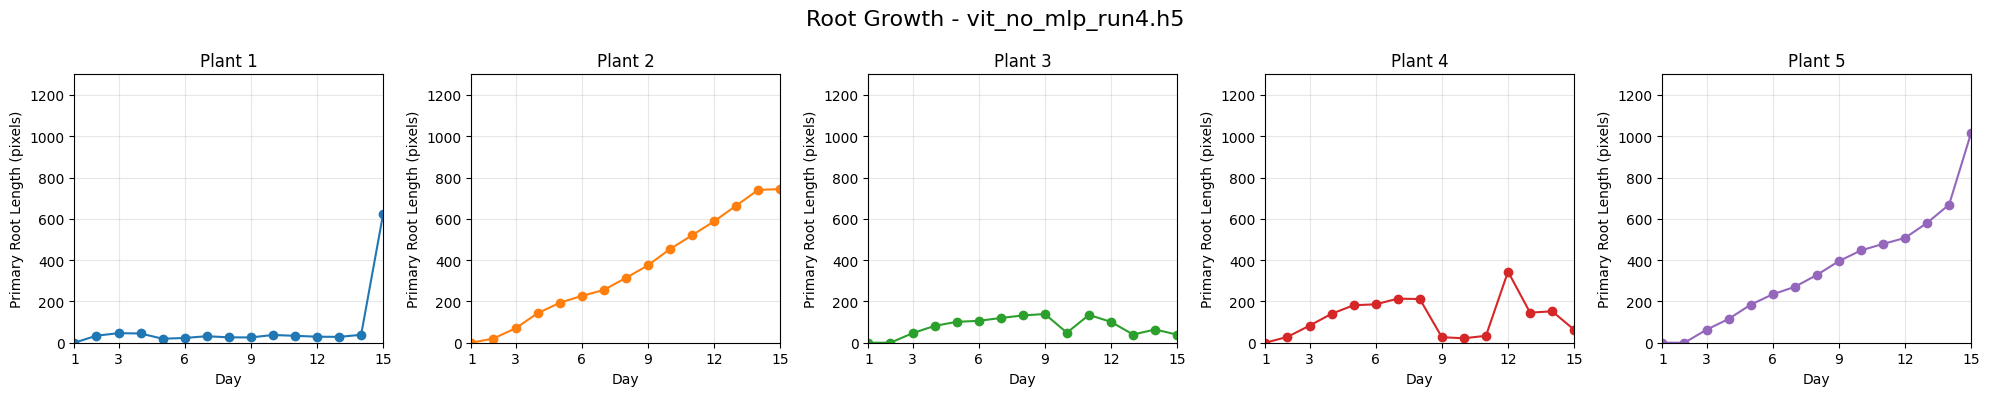


Processing model: vit_no_mlp_run5.h5


Skipping frame 28_05_01.png as ground truth has no positive pixels.

=== Average Metrics for vit_no_mlp_run5.h5 ===
Avg F1 Score: 0.7195
Avg mIoU: 0.5653
Avg Precision: 0.9154
Avg Recall: 0.5953


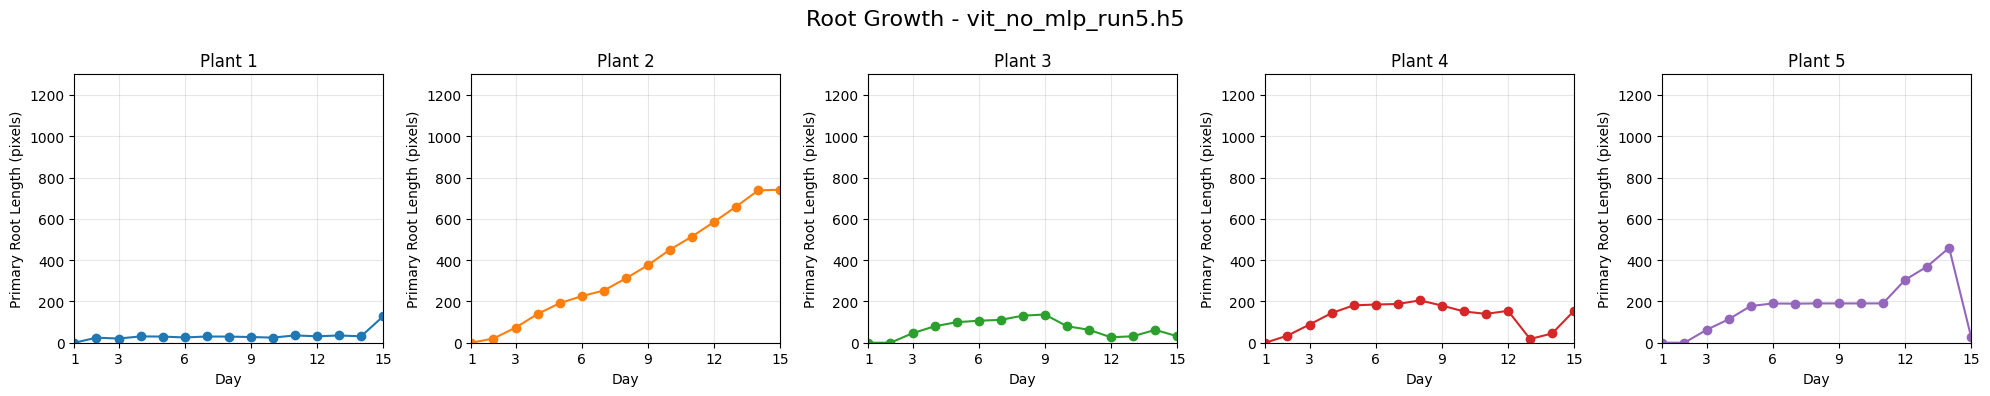


SUMMARY - All Models

vit_no_mlp_run1.h5:
  F1: 0.7308 | IoU: 0.5790 | Precision: 0.9035 | Recall: 0.6166

vit_no_mlp_run2.h5:
  F1: 0.6699 | IoU: 0.5097 | Precision: 0.9307 | Recall: 0.5285

vit_no_mlp_run3.h5:
  F1: 0.6929 | IoU: 0.5339 | Precision: 0.9309 | Recall: 0.5549

vit_no_mlp_run4.h5:
  F1: 0.7391 | IoU: 0.5888 | Precision: 0.9091 | Recall: 0.6247

vit_no_mlp_run5.h5:
  F1: 0.7195 | IoU: 0.5653 | Precision: 0.9154 | Recall: 0.5953


In [2]:
# Directory of models
model_path = 'models_vit_no_mlp'
data_dir = '../test_data_full/images/images'
results = pipeline(data_dir, model_path, view_masks=False, view_growth=True)